In [7]:
from drop_lib2 import *
from scipy.io import loadmat
import pickle

In [11]:
directory = 'catch22'
verbose = 1
data = load_data(verbose=verbose)

Loaded segments shape: (842, 25000)
Speed labels shape: (842,)
Volume labels shape: (842,)
Unique speeds: [1.72 2.08 2.36 2.64 3.13 3.39 3.42]
Unique volumes: [55 77]


In [6]:
from aeon.transformations.collection.feature_based import Catch22
tnt = Catch22(outlier_norm=False,
              catch24=True,
              n_jobs=6)
tnt.fit(data['segments'])
X_catch22 = tnt.transform(segments)
# save X_catch22 to pickle file
with open('./catch22/feat_catch22.pkl', 'wb') as f:
    pickle.dump(X_catch22, f)

In [8]:
# load X_catch22 from pickle file
with open('./catch22/feat_catch22.pkl', 'rb') as f:
    X_catch22 = pickle.load(f)

X = X_catch22

In [9]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Define the parameter grid for HistGradientBoostingClassifier
param_grid_hgb = {
    'histgradientboostingclassifier__learning_rate': [0.01, 0.05],
    'histgradientboostingclassifier__max_iter': [100, 250],
    'histgradientboostingclassifier__max_depth': [5, 15]
}

# Create a pipeline with StandardScaler and HistGradientBoostingClassifier
pipeline_speed = make_pipeline(StandardScaler(), HistGradientBoostingClassifier())
pipeline_volume = make_pipeline(StandardScaler(), HistGradientBoostingClassifier())

# Perform grid search for HistGradientBoostingClassifier
grid_search_hgb_speed = GridSearchCV(pipeline_speed, param_grid_hgb, cv=5, n_jobs=9, verbose=2)
grid_search_hgb_volume = GridSearchCV(pipeline_volume, param_grid_hgb, cv=5, n_jobs=9, verbose=2)
grid_search_hgb_speed.fit(X, speed_labels)
grid_search_hgb_volume.fit(X, volume_labels)
best_hgb_speed_params = grid_search_hgb_speed.best_params_
best_hgb_volume_params = grid_search_hgb_volume.best_params_
print(f'Best parameters for HGB speed: {best_hgb_speed_params}')
print(f'Best parameters for HGB volume: {best_hgb_volume_params}')

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters for HGB speed: {'histgradientboostingclassifier__learning_rate': 0.05, 'histgradientboostingclassifier__max_depth': 5, 'histgradientboostingclassifier__max_iter': 250}
Best parameters for HGB volume: {'histgradientboostingclassifier__learning_rate': 0.01, 'histgradientboostingclassifier__max_depth': 15, 'histgradientboostingclassifier__max_iter': 250}


 20%|██        | 1/5 [00:01<00:07,  1.80s/it]

Velocity accuracy (fold): 0.7988


 40%|████      | 2/5 [00:03<00:05,  1.78s/it]

Velocity accuracy (fold): 0.7396


 60%|██████    | 3/5 [00:05<00:03,  1.88s/it]

Velocity accuracy (fold): 0.7381


 80%|████████  | 4/5 [00:07<00:01,  2.00s/it]

Velocity accuracy (fold): 0.7798


100%|██████████| 5/5 [00:09<00:00,  1.97s/it]


Velocity accuracy (fold): 0.8036
Velocity accuracy average across all folds: 0.7720±0.0282


 20%|██        | 1/5 [00:00<00:02,  1.73it/s]

Volume accuracy (fold): 0.7811


 40%|████      | 2/5 [00:01<00:01,  1.69it/s]

Volume accuracy (fold): 0.7219


 60%|██████    | 3/5 [00:01<00:01,  1.68it/s]

Volume accuracy (fold): 0.8036


 80%|████████  | 4/5 [00:02<00:00,  1.62it/s]

Volume accuracy (fold): 0.8333


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]

Volume accuracy (fold): 0.8095
Volume accuracy average across all folds - : 0.7899±0.0378
Results saved in directory: ./catch22/
[[ 85   1   8   1   0   3   5]
 [  3  89   3   7   4  16   0]
 [  7   9  80   5   0   9   3]
 [  0   6   5 157   2  11   1]
 [  0   1   1   2  57   2  25]
 [  2   5   3  11   0 121   0]
 [  1   2   2   3  22   1  61]]
[[269 100]
 [ 77 396]]


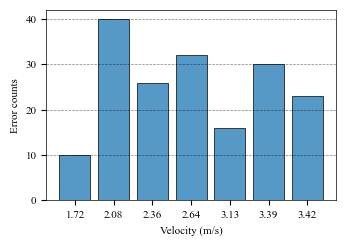

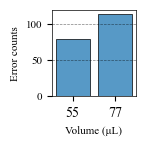

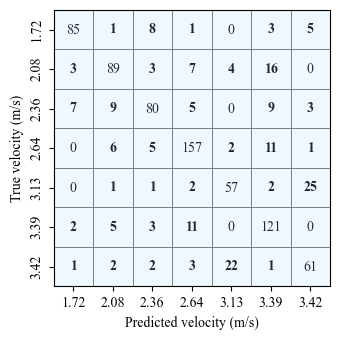

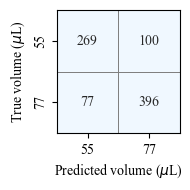

In [12]:
# Train the models with the best parameters
best_hgb_speed = make_pipeline(HistGradientBoostingClassifier(**{k.split('__')[1]: v for k, v in best_hgb_speed_params.items()}))
best_hgb_volume = make_pipeline(HistGradientBoostingClassifier(**{k.split('__')[1]: v for k, v in best_hgb_volume_params.items()}))

confusion_matrices_speed, error_indices_speed, all_cv_scores_speed, \
confusion_matrices_volume, error_indices_volume, all_cv_scores_volume = evaluate_classifier(best_hgb_speed, best_hgb_volume, X, data, random_state=42)
save_results(confusion_matrices_speed, error_indices_speed, all_cv_scores_speed,
             confusion_matrices_volume, error_indices_volume, all_cv_scores_volume,
             data,
             directory=directory, verbose=verbose)
plot_results(confusion_matrices_speed, error_indices_speed,
             confusion_matrices_volume, error_indices_volume,
             data,
             directory=directory, verbose=verbose)